In [1]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

# Extract the data

In [3]:
# extract the data of the first sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_task_execution = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx')
ds_task_execution_original = ds_task_execution.copy()

In [4]:
# extract the data of the second sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_user_info = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx', sheet_name=1)
ds_user_info_original = ds_user_info.copy()

In [5]:
# extract the data of the third sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_specific_request = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx', sheet_name=2)
ds_specific_request_original = ds_specific_request.copy()

In [6]:
# extract the data of the fourth sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_rejections = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx', sheet_name=3)
ds_rejections_original = ds_rejections.copy()

# 1. Data Exploration and Preparation

### 1.1. Task Execution 

In [7]:
ds_task_execution.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Actvity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299


In [8]:
ds_task_execution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209017 entries, 0 to 209016
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Task Id                   209017 non-null  int64  
 1   Request Identifier        209017 non-null  int64  
 2   Task arrival date         209017 non-null  object 
 3   Task capture date         209017 non-null  object 
 4   Task execution end date   209017 non-null  object 
 5   Task predicted end date   163232 non-null  object 
 6   Actvity ID                209017 non-null  int64  
 7   Task Executer             188888 non-null  float64
 8   Task executer department  181887 non-null  float64
 9   Task Type                 209017 non-null  object 
 10  Action                    124576 non-null  object 
 11  idBPMApplicationAction    209017 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 19.1+ MB


In [9]:
# Rename the column Actvity ID to Activity ID
ds_task_execution.rename(columns={'Actvity ID': 'Activity ID'}, inplace=True)

In [10]:
# Check for nulls
ds_task_execution.isnull().sum()

Task Id                         0
Request Identifier              0
Task arrival date               0
Task capture date               0
Task execution end date         0
Task predicted end date     45785
Activity ID                     0
Task Executer               20129
Task executer department    27130
Task Type                       0
Action                      84441
idBPMApplicationAction          0
dtype: int64

In [11]:
# os nulls da Task predicted end date são todos do task type 'initial request', acho q era suposto

In [12]:
# Check for duplicates
ds_task_execution.duplicated().sum()

0

In [13]:
ds_task_execution['Task Id'].value_counts()

1584303    1
3945953    1
3945749    1
3947939    1
3948764    1
          ..
2528343    1
2528344    1
2531841    1
2532500    1
6863412    1
Name: Task Id, Length: 209017, dtype: int64

In [14]:
ds_task_execution['Request Identifier'].value_counts()

38251    26
14835    22
42129    22
27606    21
38766    20
         ..
7698      2
39088     2
27537     2
29429     2
45449     2
Name: Request Identifier, Length: 45772, dtype: int64

In [15]:
# Create a new column with the last Activity ID for each Request Identifier
ds_task_execution['Last Activity ID'] = ds_task_execution.groupby('Request Identifier')['Activity ID'].transform('last')
ds_task_execution.head(12)

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Last Activity ID
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,107
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,107
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,107
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,107
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,107
5,1586253,2,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,NaN,100,598.0,606.0,Initial Request,Submit initial request,270,107
6,1586254,2,2022-04-12 10:50:26.147,2022-04-12 10:52:00.203,2022-04-12 12:35:56.390,2022-04-13 08:50:26.197,102,4322.0,1104.0,Execution,NaN,273,107
7,1587111,2,2022-04-12 12:35:56.890,2022-04-12 13:44:25.607,2022-04-12 13:45:24.067,2022-04-13 10:35:56.930,103,10606.0,NaN,Execution,NaN,273,107
8,1587525,2,2022-04-12 13:45:24.847,2022-04-12 13:53:42.120,2022-04-12 14:18:35.850,2022-04-13 11:45:24.960,104,598.0,606.0,Execution,Task executed with success,282,107
9,1587689,2,2022-04-12 14:18:36.880,2022-04-12 14:21:47.677,2022-04-12 14:23:32.340,2022-04-20 09:18:36.940,107,598.0,606.0,Final task,Request accepted by requester,299,107


In [16]:
# Check all the last activities
ds_task_execution['Last Activity ID'].value_counts()

107    123202
104     79014
101      6485
102       306
105         6
103         4
Name: Last Activity ID, dtype: int64

In [17]:
# Define the output based on the last activity
last_activity_output_map = {
    107: 'Request Finished',
    102: 'Request Canceled',
    101: 'Request Canceled',
    104: 'Closed administratively Requester Rejects Accounting Impact',
    106: 'Closed administratively', # there isn't a last activity ID 106 but this would be the output
    103: 'Closed administratively',
    108: 'Closed administratively'
}

In [18]:
# Create new column with the output
ds_task_execution['Output'] = ds_task_execution['Last Activity ID'].map(last_activity_output_map)
ds_task_execution.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Last Activity ID,Output
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,107,Request Finished
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,107,Request Finished
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,107,Request Finished
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,107,Request Finished
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,107,Request Finished


In [19]:
ds_task_execution.shape

(209017, 14)

In [20]:
# Example when the Request Identifier is 1
ds_task_execution[ds_task_execution['Request Identifier'] == 1]

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Last Activity ID,Output
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,107,Request Finished
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,107,Request Finished
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,107,Request Finished
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,107,Request Finished
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,107,Request Finished


### 1.2. User Information

In [21]:
ds_user_info.head()

,Task Executer,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer
0,1872,F,1988,1,Yes,2024,N
1,11133,F,1975,1,Yes,2019,N
2,10332,F,1978,2,Yes,2019,N
3,10349,F,1976,3,Yes,2024,N
4,1394,F,1984,4,Yes,2021,N


In [22]:
ds_user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Task Executer  11370 non-null  int64 
 1   Sex            11370 non-null  object
 2   BirthYear      11370 non-null  int64 
 3   Role ID        11370 non-null  int64 
 4   Is Manager     11370 non-null  object
 5   OrgUnitSince   11370 non-null  int64 
 6   IsOutSourcer   11370 non-null  object
dtypes: int64(4), object(3)
memory usage: 621.9+ KB


In [23]:
# Check for nulls
ds_user_info.isnull().sum()

Task Executer    0
Sex              0
BirthYear        0
Role ID          0
Is Manager       0
OrgUnitSince     0
IsOutSourcer     0
dtype: int64

In [24]:
# Check for duplicates
ds_user_info.duplicated().sum()

24

In [25]:
# Remove duplicates
ds_user_info.drop_duplicates(inplace=True)
ds_user_info.duplicated().sum()

0

In [26]:
ds_user_info['Task Executer'].value_counts()

7779     6
7457     5
6955     5
1341     5
1728     5
        ..
10606    1
8650     1
8172     1
8557     1
1257     1
Name: Task Executer, Length: 11274, dtype: int64

In [27]:
# Rows with task executer 1728 for example
task_executer_1728 = ds_user_info[ds_user_info['Task Executer'] == 1728]
print(task_executer_1728)

       Task Executer Sex  BirthYear  Role ID Is Manager  OrgUnitSince  \
1390            1728   M       1963       74        Yes          2022   
5420            1728   M       1963       80        Yes          2018   
7106            1728   M       1963       73        Yes          2022   
9970            1728   M       1963       75        Yes          2022   
10020           1728   M       1963       71        Yes          2018   

      IsOutSourcer  
1390             N  
5420             N  
7106             N  
9970             N  
10020            N  


In [28]:
# pa isto n faz sentido nenhum, n percebi
# os numeros que aparecem varias vezes acho q nao estao na ds_task_execution

### 1.3. Specific Request

In [29]:
ds_specific_request.head()

,idField,Request Identifier,Value
0,47,328,0
1,47,327,0
2,47,291,0
3,47,289,0
4,47,219,0


In [30]:
ds_specific_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297556 entries, 0 to 297555
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   idField             297556 non-null  int64 
 1   Request Identifier  297556 non-null  int64 
 2   Value               297556 non-null  object
dtypes: int64(2), object(1)
memory usage: 6.8+ MB


In [31]:
# Check for nulls
ds_specific_request.isnull().sum()

idField               0
Request Identifier    0
Value                 0
dtype: int64

In [32]:
# Check for duplicates
ds_specific_request.duplicated().sum()

0

In [33]:
ds_specific_request['Request Identifier'].value_counts()

328      10
4282     10
3525     10
3480     10
3445     10
         ..
20478     4
20376     4
22208     4
21248     4
37102     4
Name: Request Identifier, Length: 45772, dtype: int64

In [34]:
# Rows with Request Identifier 328 for example
request_identifier_328 = ds_specific_request[ds_specific_request['Request Identifier'] == 328]
print(request_identifier_328)

        idField  Request Identifier                     Value
0            47                 328                         0
16         1602                 328                         0
88978      3491                 328                        10
89147      3420                 328                        10
89476      3486                 328                        10
89856      3388                 328                        10
90166      3390                 328                        10
90544      3391                 328                        10
139116      203                 328  2022-05-08T23:00:00.000Z
290060     1604                 328                        80


### 1.4. Rejections

In [35]:
ds_rejections.head()

,Task Id,idBPMRequirement
0,1606251,191
1,1606786,183
2,1629944,183
3,1643257,183
4,1643929,183


In [36]:
ds_rejections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Task Id           4099 non-null   int64
 1   idBPMRequirement  4099 non-null   int64
dtypes: int64(2)
memory usage: 64.2 KB


In [37]:
# Check for nulls
ds_rejections.isnull().sum()

Task Id             0
idBPMRequirement    0
dtype: int64

In [38]:
# Check for duplicates
ds_rejections.duplicated().sum()

0

In [39]:
ds_rejections['Task Id'].value_counts()

1654061    7
1647860    6
1925405    2
2999956    2
3139691    2
          ..
3266189    1
3266202    1
3266928    1
3267685    1
6636734    1
Name: Task Id, Length: 4056, dtype: int64

In [40]:
# Rows with Task Id 1654061 for example
task_id_1654061 = ds_rejections[ds_rejections['Task Id'] == 1654061]
print(task_id_1654061)

    Task Id  idBPMRequirement
20  1654061               183
21  1654061               191
22  1654061               300
23  1654061               331
24  1654061               353
25  1654061               661
26  1654061              1436


### 1.5. Aggregate the datasets ?

In [41]:
# Merge the Task Execution with the User Information by Task Executer
ds_joined = pd.merge(ds_task_execution, ds_user_info, on='Task Executer', how='left')
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Last Activity ID,Output,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,107,Request Finished,M,1967.0,5.0,Yes,2021.0,N
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,107,Request Finished,F,1967.0,21.0,No,2024.0,Y
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,107,Request Finished,F,1975.0,11.0,Yes,2023.0,N
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,107,Request Finished,M,1967.0,5.0,Yes,2021.0,N
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,107,Request Finished,M,1967.0,5.0,Yes,2021.0,N


In [42]:
ds_joined.shape

(209017, 20)

In [43]:
# Aggregate the columns 'idField' and 'Value' from ds_specific_request to merge with ds_joined
ds_specific_request_aggregated = ds_specific_request.groupby('Request Identifier').agg({
    'idField': lambda x: ','.join(map(str, x)),
    'Value': lambda x: ','.join(map(str, x))
}).reset_index()

ds_specific_request_aggregated.head()

,Request Identifier,idField,Value
0,1,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90"
1,2,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,2022-04-11T23:00:00.000Z"
2,3,"3390,3420,203,3388,3486","10,10,2022-04-11T23:00:00.000Z,30,30"
3,4,"3486,3388,3390,3420,203","10,10,10,20,2022-04-12T23:00:00.000Z"
4,5,"3391,3420,3491,3388,203,3390,3486","10,10,20,20,2022-04-05T23:00:00.000Z,30,30"


In [44]:
# Merge the ds_joined with the ds_specific_request_aggregated by Request Identifier
ds_joined = pd.merge(ds_joined, ds_specific_request_aggregated, on='Request Identifier', how='left')
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Last Activity ID,Output,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,...,107,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90"
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,...,107,Request Finished,F,1967.0,21.0,No,2024.0,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90"
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,...,107,Request Finished,F,1975.0,11.0,Yes,2023.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90"
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,...,107,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90"
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,...,107,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90"


In [45]:
ds_joined.shape

(209017, 22)

In [46]:
# Aggregate the column 'idBPMRequirement' from ds_rejections to merge with ds_joined
ds_rejections_aggregated = ds_rejections.groupby('Task Id').agg({
    'idBPMRequirement': lambda x: ','.join(map(str, x))}).reset_index()

ds_rejections_aggregated.head()

,Task Id,idBPMRequirement
0,1606251,191
1,1606786,183
2,1629944,183
3,1643257,183
4,1643929,183


In [47]:
# Check if the values from the column 'idBPMRequirement' are aggregated
agg_task_id_1654061 = ds_rejections_aggregated[ds_rejections_aggregated['Task Id'] == 1654061]
print(agg_task_id_1654061)

    Task Id              idBPMRequirement
15  1654061  183,191,300,331,353,661,1436


In [48]:
# Merge the ds_joined with the ds_rejections_aggregated by Task Id
ds_joined = pd.merge(ds_joined, ds_rejections_aggregated, on='Task Id', how='left')
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Output,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,...,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90",NaN
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,...,Request Finished,F,1967.0,21.0,No,2024.0,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90",NaN
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,...,Request Finished,F,1975.0,11.0,Yes,2023.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90",NaN
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,...,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90",NaN
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,...,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,2022-04-10T23:00:00.000Z,90",NaN


In [49]:
# ainda ha varias rows para o mesmo Case Id (Request Identifier)

In [50]:
ds_joined.shape

(209017, 23)

In [51]:
# Change the columns data types
cols_to_object = ['Task Id', 'Request Identifier', 'Activity ID', 'Task Executer', 'Task executer department', 'idBPMApplicationAction', 'Last Activity ID', 'Role ID']
for col in cols_to_object:
    ds_joined[col] = ds_joined[col].astype('object')

ds_joined['Task arrival date'] = pd.to_datetime(ds_joined['Task arrival date'])
ds_joined['Task capture date'] = pd.to_datetime(ds_joined['Task capture date'])
ds_joined['Task execution end date'] = pd.to_datetime(ds_joined['Task execution end date'])
ds_joined['Task predicted end date'] = pd.to_datetime(ds_joined['Task predicted end date'])

In [52]:
ds_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209017 entries, 0 to 209016
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Task Id                   209017 non-null  object        
 1   Request Identifier        209017 non-null  object        
 2   Task arrival date         209017 non-null  datetime64[ns]
 3   Task capture date         209017 non-null  datetime64[ns]
 4   Task execution end date   209017 non-null  datetime64[ns]
 5   Task predicted end date   163232 non-null  datetime64[ns]
 6   Activity ID               209017 non-null  object        
 7   Task Executer             188888 non-null  object        
 8   Task executer department  181887 non-null  object        
 9   Task Type                 209017 non-null  object        
 10  Action                    124576 non-null  object        
 11  idBPMApplicationAction    209017 non-null  object        
 12  La

### 1.6. Outliers

In [53]:
# Select only the numerical columns
numerical_cols_ds_joined = ds_joined.select_dtypes(include=['int64', 'float64']).columns

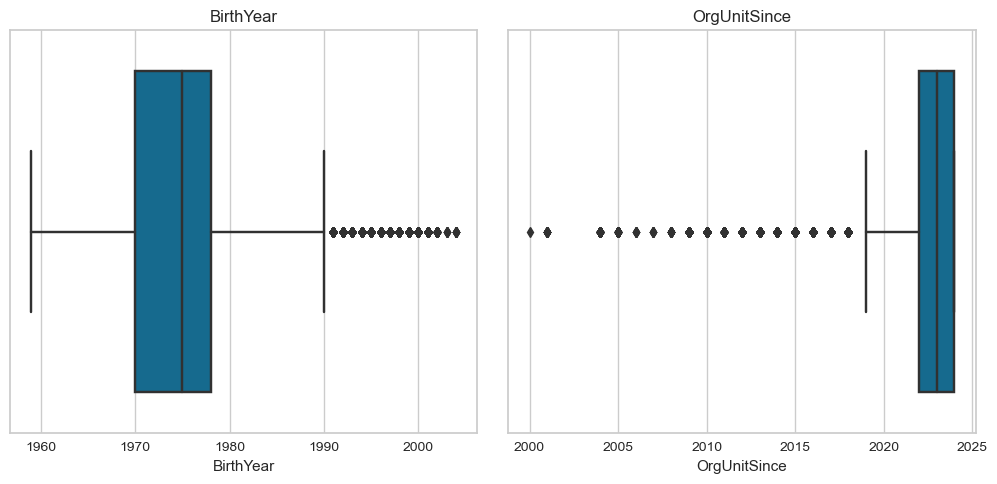

In [54]:
# Boxplots (numerical columns)
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols_ds_joined, 1):
    plt.subplot(len(numerical_cols_ds_joined) // 3 + 1, 3, i)
    sns.boxplot(x=ds_joined[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [76]:
# looping cases podem ser outliers?
ds_joined['Request Identifier'].value_counts()

38251    26
14835    22
42129    22
27606    21
38766    20
         ..
7698      2
39088     2
27537     2
29429     2
45449     2
Name: Request Identifier, Length: 45772, dtype: int64

In [77]:
ds_joined['Request Identifier'].value_counts().mean()

4.566481691864022

### 1.7. Missing Values
     
     We will take different approaches to impute missing values of different variables, depending on the % of missing values and what makes more sense given the context and our understanding of the variable in cause 

In [56]:
ds_joined.isna().sum()

Task Id                          0
Request Identifier               0
Task arrival date                0
Task capture date                0
Task execution end date          0
Task predicted end date      45785
Activity ID                      0
Task Executer                20129
Task executer department     27130
Task Type                        0
Action                       84441
idBPMApplicationAction           0
Last Activity ID                 0
Output                           6
Sex                          20129
BirthYear                    20129
Role ID                      20129
Is Manager                   20129
OrgUnitSince                 20129
IsOutSourcer                 20129
idField                          0
Value                            0
idBPMRequirement            205471
dtype: int64

#### - Task predicted end date

In [57]:
task_type_initial_request = ds_joined[ds_joined['Task Type'] == 'Initial Request']
task_type_initial_request.shape

(45772, 23)

In [58]:
# quase todos os nans sao initial request provavelmente, preencher com 'Not necessary'?
# os restantes casos ainda n sei

#### - Task Executer

In [59]:
ds_joined['Task Executer'].value_counts()

10606.0    32987
4960.0     17347
4731.0     13017
4322.0     12438
10925.0     2352
           ...  
705.0          1
9069.0         1
10875.0        1
9410.0         1
331.0          1
Name: Task Executer, Length: 1648, dtype: int64

In [60]:
# preencher com 'Unknown'? ou tentar com knn por ex

#### - Task executer department

In [61]:
ds_joined['Task executer department'].value_counts()

1146.0    27393
1104.0    22335
1147.0    18739
1172.0     7800
1177.0     4557
          ...  
307.0         1
454.0         1
309.0         1
113.0         1
370.0         1
Name: Task executer department, Length: 391, dtype: int64

In [62]:
# preencher com 'Unknown'? ou tentar com knn por ex

#### - Action

In [63]:
ds_joined['Action'].value_counts()

Submit initial request                             45775
Task executed with success                         24507
Task terminated - administrative closure           19681
Task automaticaly terminated - SLA time reached    16623
Request accepted by requester                       9056
Task returned to team                               8934
Name: Action, dtype: int64

In [64]:
# preencher com 'Unknown'?

#### - Output

In [65]:
ds_joined['Output'].value_counts()

Request Finished                                               123202
Closed administratively Requester Rejects Accounting Impact     79014
Request Canceled                                                 6791
Closed administratively                                             4
Name: Output, dtype: int64

In [66]:
ds_joined_output_nan = ds_joined[ds_joined['Output'].isna()]
ds_joined_output_nan

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Output,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
39901,2183562,8934,2022-09-19 09:10:06.913,2022-09-19 09:10:06.913,2022-09-19 09:10:06.913,NaT,100,1147.0,175.0,Initial Request,...,NaN,F,1982.0,5.0,Yes,2023.0,N,"3388,203,3420,3486,3390","10,2022-09-15T23:00:00.000Z,30,50,90",NaN
39902,2183563,8934,2022-09-19 09:10:08.320,2022-09-19 09:23:05.917,2022-09-19 09:23:05.917,2022-09-19 16:10:08.340,105,1147.0,175.0,Execution,...,NaN,F,1982.0,5.0,Yes,2023.0,N,"3388,203,3420,3486,3390","10,2022-09-15T23:00:00.000Z,30,50,90",NaN
102301,3157900,22787,2023-03-29 15:00:37.053,2023-03-29 15:00:37.053,2023-03-29 15:00:37.053,NaT,100,8303.0,707.0,Initial Request,...,NaN,M,1970.0,6.0,Yes,2018.0,N,"3486,203,3388,3390","10,2023-03-16T00:00:00.000Z,30,90",NaN
102302,3157901,22787,2023-03-29 15:00:41.083,2023-03-29 15:06:46.070,2023-03-29 15:06:46.070,2023-03-30 13:00:41.100,105,8303.0,707.0,Execution,...,NaN,M,1970.0,6.0,Yes,2018.0,N,"3486,203,3388,3390","10,2023-03-16T00:00:00.000Z,30,90",NaN
171732,4449549,38736,2023-11-03 16:45:08.440,2023-11-03 16:45:08.440,2023-11-03 16:45:08.440,NaT,100,2109.0,157.0,Initial Request,...,NaN,F,1997.0,4.0,Yes,2024.0,N,"3486,203,3388,3390","10,2023-11-03T00:00:00.000Z,50,90",NaN
171733,4449550,38736,2023-11-03 16:45:08.747,2023-11-03 16:47:15.117,2023-11-03 16:47:15.117,2023-11-06 14:45:08.823,105,2109.0,157.0,Execution,...,NaN,F,1997.0,4.0,Yes,2024.0,N,"3486,203,3388,3390","10,2023-11-03T00:00:00.000Z,50,90",NaN


In [67]:
# o 'Output' é nan qnd o last activity é 105, mas segundo o esquema o processo n pode acabar no 105
# preencher com resultado mais frequente? como são só 6 nans, ou 3 qnd passar para 1 linha por case id

#### - User information data (Sex, BirthYear, Role ID, IS Manager, OrgUnitSince, IsOutSourcer)

In [68]:
# Check if all task executers from ds_task_execution are in ds_user_info
all_task_executers_in_ds_user_info = set(ds_user_info['Task Executer'].unique())
task_executers_in_ds_task_execution = set(ds_task_execution['Task Executer'].unique())

if all(task_executer in all_task_executers_in_ds_user_info for task_executer in task_executers_in_ds_task_execution):
    print("All task executers from ds_task_execution are in ds_user_info.")
else:
    print("There are task executers in ds_task_execution that are not in ds_user_info.")

There are task executers in ds_task_execution that are not in ds_user_info.


In [69]:
# nao temos dados de alguns users, preencher com 'Unknown'?

#### - idBPMRequirement

In [70]:
ds_joined['idBPMRequirement'].value_counts()

183                             1547
300                             1472
331                              196
191                              138
353                               99
661                               54
183,300                           14
183,353                           10
1436                               8
300,353                            2
191,300,331,353,661,1436           1
183,191,300,331,353,661,1436       1
183,331                            1
300,331                            1
183,191                            1
300,1436                           1
Name: idBPMRequirement, dtype: int64

In [71]:
# preencher com 'Not Applicable'?

# 2. Feature Engineering

### 2.1. Encoding

### 2.1. Feature Creation

In [72]:
# :>

In [73]:
# request identifier -> case id
# predict the last activity before the end 
# add the column with the 4 possible ends
# (classification problem)
# looping outlier ?
# encoding, columns for the activities
# 3 activities ?
# nans

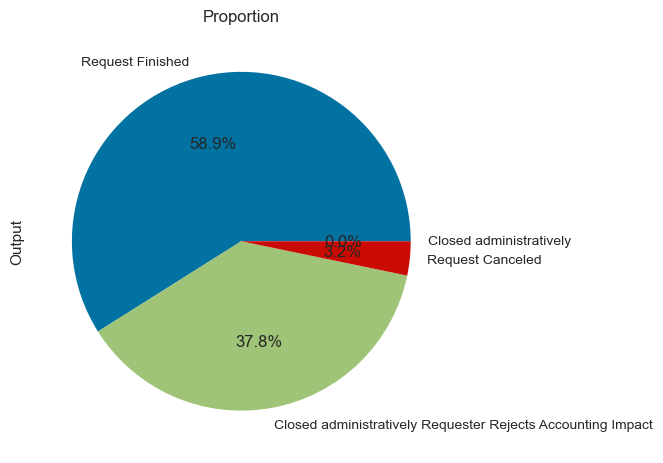

In [74]:
# Data Visualization (Outputs proportion)
ds_joined.Output.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion")
plt.show()